In [139]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [140]:
import eds 
import simpy
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import show as sh
import requests
import folium
import haversine
import math
import bibliothek as bib
import random

## Data Generation

In [141]:
CONFIG = {}

CONFIG['LAT'] = 51.34083598409240
CONFIG['LON'] = 12.381819774766130
CONFIG['RADIUS'] = 300
CONFIG['NUM_UES'] = 400
CONFIG['URL'] = 'https://pqos-api-test.radiolab.dit.htwk-leipzig.de' 

In [142]:
def create_sector_shape(lon, lat, dir=0, width=120):
    p = [(lat, lon)]
    n_points = 10
    
    for a in range(n_points):
        p.append(haversine.inverse_haversine(p[0], 0.05, (dir - width/2 + width/n_points*a)/180.0 * math.pi))
    
    p.append(p[0])
    return p

In [143]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)

ul_query_string = CONFIG['URL'] + '/generate_scenario' + \
                                  '?lat=' + str(CONFIG['LAT']) + \
                                  '&lon=' + str(CONFIG['LON']) + \
                                  '&radius=' + str(CONFIG['RADIUS']) + \
                                  '&num_ues=' + str(CONFIG['NUM_UES']) + \
                                '&cell_type=NGMN3600'

ul_response_data = requests.get(ul_query_string).json()
ue_data = ul_response_data['ue_data']
cell_data=ul_response_data['cell_data']
        
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    cell_color = '#ea0a8e'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)


display(ul_scenario_map)

In [144]:
df_ue=pd.DataFrame(ue_data)

In [145]:
df_cell = pd.DataFrame(cell_data)

In [146]:
sectors=df_cell['pci'].unique()

In [147]:
bs_dict={}
for i in df_cell.index:
    bs_dict.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lon'],df_cell.loc[i]['lat']]})

In [148]:
user_dataframe=pd.DataFrame()
x=np.array([])
for i in df_ue['id']:
    dic=df_ue.loc[i]['cell_info']
    powers={}
    pos=df_ue.loc[i]['pos']
    powers.update({'lat':pos[0]})
    powers.update({'lon':pos[1]})
    for i in dic:
        powers.update({i['pci']:i['dl_rx_power']})
    x=np.append(x,powers)
user_dataframe = pd.DataFrame.from_records(x)

## Preprocessing & CoMP Calculations

Settings for the CoMP Calculations: 
* noise power = -104 dBm

P=vector with receiving powers from all PCIs (N)

**SINR without CoMP**: $\frac{P_{0}}{P_{N}+P_{1:N}}$

**SINR with CoMP (2 coord. PCIs)** : $\frac{(\sqrt{P_{0}}+\sqrt{P_{1}})^2}{P_{N}+P_{2:N}}$

In [149]:
noise=np.power(10,-104/10) #https://www.sciencedirect.com/topics/engineering/noise-power -> 10MHz bandwidth (50PRBs)
cluster=sectors #all the cells are put in one cluster

In [150]:
df=user_dataframe.copy()
SINR_list=np.array([])
SINR_CoMP_list=np.array([])
c_cell=np.array([])
s_cell=np.array([])
for i in np.arange(0, len(df)):
    P=df.loc[i,:][2:] #goes through file line by line and selects the line
    P=np.power(10, P/10) # calculate the linear values for capacity calculations
    P=P.sort_values(ascending=False) # sort values by their order
    A=np.sqrt(P) #calculate the amplitude
    index=P.index.values #Extract all index values 
    index=index.astype(np.int) #PCIen as integer
    A=np.array(A)
    P=np.array(P)
    pci_coord= index[1]
    SINR= P[0]/(np.sum(P[1:])+noise)
    SINR_CoMP= np.power(np.sum(A[0:2]),2)/(np.sum(P[2:])+noise)
    SINR_list=np.append(SINR_list,10*np.log10(SINR)) #appends the calculated elements
    SINR_CoMP_list=np.append(SINR_CoMP_list,10*np.log10(SINR_CoMP))
    s_cell=np.append(s_cell,index[0])
    c_cell=np.append(c_cell,index[1])

##### Building the dataframe

In [151]:
df['lat']=user_dataframe['lat']
df['lon']=user_dataframe['lon']
df['SINR [dB]']=SINR_list
df['SINR-CoMP [dB]']=SINR_CoMP_list
df['PCI Serving']=s_cell.astype(int)
df['PCI Coord']=c_cell.astype(int)
df['qos']=np.zeros(len(user_dataframe)) #not needed here -> all users are best effort -> 0
df['id']=np.arange(0,len(user_dataframe))

#### Sort out PCIs that have less than 10 users -> edge of the Scenario

In [152]:
#check if the number of users (positions) for the serving pci is >10
df_f=df.groupby('PCI Serving')
count=0
for i in df['PCI Serving'].unique():
    k=df_f.get_group(i)
    if(len(k)<10):
        cluster=np.delete(cluster,count) #delete cells with less than 10 positions
        df=df[df['PCI Serving']!=i]
    count+=1

#### Define general parameters for the simulation
if it says "sinr out of range" thats because the sinr is just restricted up to 30 dB

In [153]:
cluster=[133,775]
#cluster=[134,133,775,319]

max_prb=50 #max number of prbs
ue_nr=15 #number of ues per pci
metric=[1,1] #standard metric is pf


index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

size=4000 #size of each packets that arrives from a user (Bit)
env=simpy.Environment()

#ues are initialized 
ue_dict=eds.df_to_ue_lists(df,cluster,6,env) #ue_dict is dict with all users from the dataframe from the defined cluster

#defines when comp can be used ->only if the second strongest pci is really the contained in the cluster
#ue_dict2=eds.restrict_users_to_cluster(ue_dict,cluster)

# select only ue_nr of users from given index 
ue_dict_red,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

## Analysis for mu = 4ms (av. packet arrival time)

In [154]:
r='random' 
r='deterministic'

mu=4
env=simpy.Environment()
sched_l=[]
sched3=eds.sched_inst(env)
for i in cluster:
    sched1=eds.sched_inst(env)
    sched_l.append(eds.sched_inst(env))

ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
        counter+=1    
ue_dict_red,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)


prb_number_comp=eds.calculate_prb_number2(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp

env=simpy.Environment()

SCHEDULE_T=2 #Clock of scheduler -> every 2ms

SCHEDULE_T=2 #Clock des Schedulers 
for i in cluster:
    ue_list=ue_dict_red[i]
    for j in ue_list:
        env.process(j.best_effort_stat(env,mu))
    

ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
for i in cluster:
    ue_list=ue_dict_red[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp

env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
    counter=counter+1
timer=2000
env.run(until=timer)

4000
4000
8000
12000
4000
12000
16000
12000
20000
16930.0
4000
13438.0
24435.0
28000
28000
5261.0
17261.0
8000
17778.0
19796.0
28640.0
29869.0
8000.0
40870.0
48040.0
36500.0
28640.0
21057.0
33360.0
57280.0
42808.0
17261.0
61305.0
48080.0
33280.0
41000.0
50318.0
40942.0
69920.0
47747.0
81740.0
14522.0
49920.0
59579.0
76120.0
53500.0
70560.0
52524.0
64686.0
98175.0
19783.0
70560.0
72840.0
71200.0
80160.0
60106.0
73625.0
82000.0
122610.0
37044.0
79200.0
82101.0
83840.0
82564.0
83688.0
108200.0
147045.0
98500.0
42305.0
103362.0
95840.0
108480.0
87503.0
147480.0
91270.0
112240.0
51566.0
135000.0
116623.0
108480.0
109120.0
167915.0
120442.0
90852.0
60827.0
112280.0
143500.0
125884.0
113120.0
125760.0
188350.0
133381.0
106434.0
74088.0
124320.0
156000.0
127145.0
129760.0
216785.0

C:\Users\Caroline Zoll\EDS\eds.py:225: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eds.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))



142400.0
138320.0
103349.0
118016.0
120360.0
148500.0
136406.0
134400.0
233220.0
159040.0
143259.0
112610.0
133598.0
120400.0
129667.0
237655.0
147040.0
153000.0
159680.0
148198.0
121871.0
137180.0
146928.0
266090.0
132440.0
155680.0
168320.0
165500.0
165137.0
131132.0
160762.0
282525.0
160189.0
164320.0
148480.0
176960.0
186076.0
202000.0
140393.0
164344.0
294960.0
193450.0
192960.0
173600.0
152520.0
195015.0
198500.0
149654.0
311395.0
183926.0
206711.0
197600.0
198240.0
199954.0
148560.0
162915.0
211000.0
327830.0
187508.0
215972.0
210240.0
202880.0
204893.0
168176.0
168600.0
336265.0
219500.0
221233.0
191090.0
234880.0
215520.0
217832.0
185437.0
160640.0
348700.0
224000.0
250494.0
190672.0
243520.0
236160.0
230771.0
194698.0
361135.0
164680.0
279755.0
224500.0
190254.0
252160.0
232800.0
247710.0
207959.0
397570.0
293016.0
184720.0
225000.0
185836.0
264800.0
237440.0
256649.0
213220.0
402005.0
306277.0
188760.0
269440.0
250080.0
193418.0
245500.0
253588.0
410440.0
242481.0
315538.0


### Graph Visualization

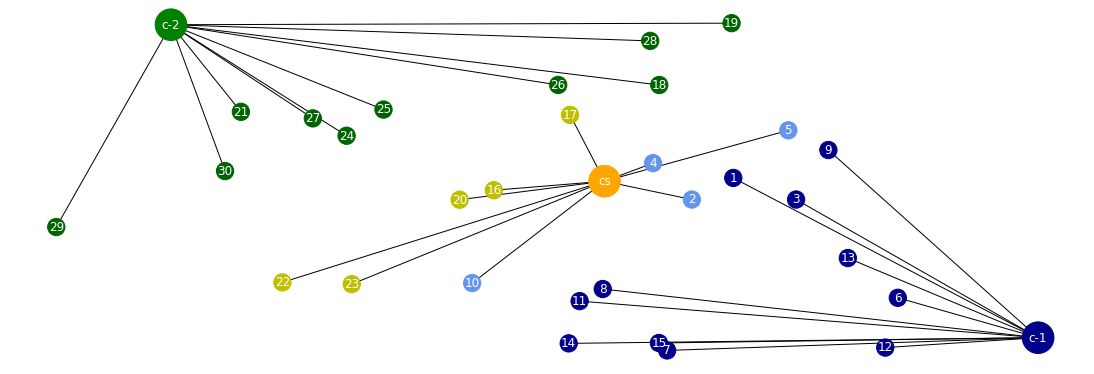

In [155]:
import plotly.graph_objects as go
import networkx as nx

mode='user-assignment'
#mode='comp-gain'

df2 = pd.read_json("Prepro/cell_data.txt")
#bs_dict={}
#for i in df_cell.index:
 #   bs_dict.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lat'],df_cell.loc[i]['lon']]})
    
BS_pos=np.array([])
for i in cluster:
    BS_pos=np.append(BS_pos,bs_dict[i])

G=nx.Graph()

x=np.arange(1,ue_nr*2)
G.add_node('cs')
G.add_node('c-1')
G.add_node('c-2')

loc_dic={}
loc_dic.update({'cs':[(BS_pos[1]+BS_pos[3])/2,(BS_pos[0]+BS_pos[2])/2]})
loc_dic.update({'c-1':[BS_pos[1],BS_pos[0]]}) 
loc_dic.update({'c-2':[BS_pos[3],BS_pos[2]]})     
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    counter+=1

G.add_nodes_from(x)

n_c=np.array(['orange','darkblue','green'])
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.x,i.y]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
        if(i.cell1==cluster[0]):
            n_c=np.append(n_c,'cornflowerblue')
        elif(i.cell1==cluster[1]):
            n_c=np.append(n_c,'y')
    else:
        if(i.cell1==cluster[0]):
            G.add_edge(counter,'c-1')
            n_c=np.append(n_c,'darkblue')
        elif(i.cell1==cluster[1]):
            G.add_edge(counter,'c-2')
            n_c=np.append(n_c,'darkgreen')
    counter+=1
            
n_s=np.ones(ue_nr*2+3)*300
n_s[0:3]=1000

m=np.array([])
m=np.append(m,[1,1,1])
t=np.array([])
t=np.append(t,[1,1,1])
for i in ue_all:
    m=np.append(m,(i.mR2/i.mR))
    if(i.comp==1):
        t=np.append(t,i.tbs2)
    else:
        t=np.append(t,i.tbs)
vmin = np.min(m)
vmax = np.max(m)
m=10*np.log10(m)

plt.figure(3,figsize=(15,5)) 
#cmap='RdBu'
cmap='RdYlGn'
if(mode=='user-assignment'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=n_c,font_color='white',node_size=n_s)
elif(mode=='comp-gain'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=m,font_color='white',node_size=n_s,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    x=plt.colorbar(sm)
    x.set_label('CoMP gain in [dB]', rotation=270,labelpad=20)
plt.draw()
plt.show()

## Numerical Results

In [156]:
df_res=eds.ue_to_df(ue_all)

In [166]:
ue_all[0].mon

{2: 12000,
 4: 12000,
 6: 6350.0,
 8: 10350.0,
 10: 14350.0,
 12: 14350.0,
 14: 18350.0,
 16: 18350.0,
 18: 22350.0,
 20: 26350.0,
 22: 26350.0,
 24: 30350.0,
 26: 30350.0,
 28: 30350.0,
 30: 30350.0,
 32: 30350.0,
 34: 34350.0,
 36: 34350.0,
 38: 38350.0,
 40: 38350.0,
 42: 42350.0,
 44: 42350.0,
 46: 42350.0,
 48: 42350.0,
 50: 46350.0,
 52: 50350.0,
 54: 44700.0,
 56: 44700.0,
 58: 44700.0,
 60: 44700.0,
 62: 44700.0,
 64: 44700.0,
 66: 48700.0,
 68: 48700.0,
 70: 48700.0,
 72: 48700.0,
 74: 48700.0,
 76: 52700.0,
 78: 52700.0,
 80: 51050.0,
 82: 51050.0,
 84: 51050.0,
 86: 55050.0,
 88: 55050.0,
 90: 55050.0,
 92: 55050.0,
 94: 55050.0,
 96: 55050.0,
 98: 55050.0,
 100: 55050.0,
 102: 59050.0,
 104: 63050.0,
 106: 67050.0,
 108: 67050.0,
 110: 64903.0,
 112: 64903.0,
 114: 64903.0,
 116: 64903.0,
 118: 72903.0,
 120: 72903.0,
 122: 67253.0,
 124: 67253.0,
 126: 67253.0,
 128: 71253.0,
 130: 71253.0,
 132: 71253.0,
 134: 71253.0,
 136: 71253.0,
 138: 75253.0,
 140: 79253.0,
 142: 87

In [157]:
df1=df_res[df_res['pci 1']==cluster[0]]
df2=df_res[df_res['pci 1']==cluster[1]]
#df3=df_res[df_res['pci 1']==cluster[2]]

for i in cluster:
    df1=df_res[df_res['pci 1']==i]
    print('average comp gain pci '+str(i)+': '+str((df1['mR gain'].mean()-1)*100)+'%')
print('average comp gain: '+str(round(((df1['mR gain'].mean()+df2['mR gain'].mean())/2-1)*100))+'%')

average comp gain pci 133: 17.4804534690022%
average comp gain pci 775: 19.300702564619954%
average comp gain: 19%


In [158]:
df_c=df_res[df_res['comp']==1]
df_nc=df_res[df_res['comp']==0]

all ues
10% Quantil: -28.30736542325821
90% Quantil: 120.10213246220788
50% Quantil (Median): -15.117430998189214
comp ues
10% Quantil: 56.08958038758839
90% Quantil: 171.66131423210254
50% Quantil (Median): 100.6472388712349
no_comp ues
10% Quantil: -28.393734669325323
90% Quantil: -14.578467412791973
50% Quantil (Median): -27.501115792749186


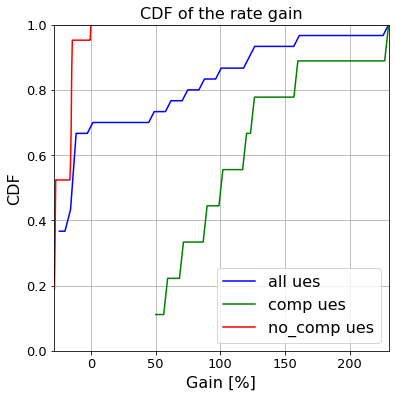

In [159]:
x=(df_res['mR gain']-1)*100
y=(df_c['mR gain']-1)*100
z=(df_nc['mR gain']-1)*100
sh.cdf_3(x,'all ues','blue',y,'comp ues','green',z,'no_comp ues','red','CDF of the rate gain',min(x),max(x),'Gain [%]',60)

all ues
10% Quantil: -1.4452549481352952
90% Quantil: 3.4261409764697213
50% Quantil (Median): -0.7118172622291441
comp ues
10% Quantil: 1.931890294774854
90% Quantil: 4.317589035824394
50% Quantil (Median): 3.024331877367539
no_comp ues
10% Quantil: -1.450489765818611
90% Quantil: -0.6843264096121325
50% Quantil (Median): -1.3966867737883915


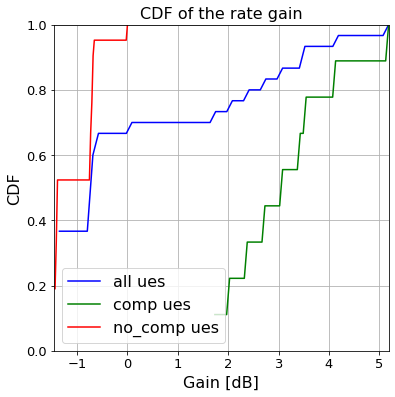

In [160]:
x=10*np.log10(df_res['mR gain'])
y=10*np.log10(df_c['mR gain'])
z=10*np.log10(df_nc['mR gain'])

sh.cdf_3(x,'all ues','blue',y,'comp ues','green',z,'no_comp ues','red','CDF of the rate gain',min(x),max(x),'Gain [dB]',60)

## Analyisis for different PRB-sizes

In [161]:
load1_l=np.array([])
load2_l=np.array([])
s_l={}
s_l2={}
mu_range=np.arange(1,40,1)
prb_dict={}
metric=[1,1]
speicher={}
#r='random'
r='deterministic'

#index=np.load('index.npy')
index=np.array([np.arange(0,ue_nr),np.arange(0,ue_nr)])


ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
ue_dict2=eds.restrict_users_to_cluster(ue_dict,cluster)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict2[i]))),ue_nr)
        counter+=1
   
for prb_number_comp in np.arange(10,40,2):
    prb_number_normal=max_prb-prb_number_comp
    for mu in mu_range:
        
        env=simpy.Environment()
        sched1=eds.sched_inst(env)
        sched2=eds.sched_inst(env)
        sched3=eds.sched_inst(env)
        sched_l=[sched1,sched2]


        ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
        #ue_dict2=eds.restrict_users_to_cluster(ue_dict,cluster)       
        ue_dict_red,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)
        

        env=simpy.Environment()
        #Start processes

        SCHEDULE_T=2 #Clock des Schedulers 
        for i in cluster:
            ue_list=ue_dict_red[i]
            for j in ue_list:
                env.process(j.best_effort_stat(env,mu))

        ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
        for i in cluster:
            ue_list=ue_dict_red[i]
            new_ue_list=np.array([])
            for j in ue_list:
                if(j.comp == 0):
                    new_ue_list=np.append(new_ue_list,j)
                else:
                    ue_comp=np.append(ue_comp,j)
            ue_dict[i]=new_ue_list #user without comp

        env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric))

        counter=0
        for i in cluster:
            ue_list=ue_dict[i]
            ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
            sched=sched_l[counter]
            env.process(sched.scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
            counter=counter+1
        timer=2000
        env.run(until=timer)
        liste=np.array([])

        for i in ue_all:
            liste=np.append(liste,((i.mR2/i.mR)-1)*100)
        speicher.update({mu:liste})

        #rem1=0
        #req1=0
        #load1=0
        #rem2=0
        #req2=0
        #load2=0
        #ind=int(timer/2-2)
        #for i in np.arange(100,ind):
         #   rem1+=sched1.rem_prb[ind]
          #  req1+=sched1.rem_req[ind]
           #  load1+=(sched1.rem_req[ind]+(max_prb-sched1.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)

#            rem2+=sched2.rem_prb[ind]
 #       req2+=sched2.rem_req[ind]
    #        load2+=(sched2.rem_req[ind]+(max_prb-sched2.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)

     #   load1_l=np.append(load1_l,load1/len(np.arange(100,ind)))
     #   load2_l=np.append(load2_l,load2/len(np.arange(100,ind)))
        
    l=np.array([])
    l2=np.array([])
    for i in ran:
        x=speicher.get(i)
        l=np.append(l,x.mean())
    s_l.update({prb_number_comp:l})


AttributeError: module 'eds' has no attribute 'restrict_users_to_cluster'

In [162]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
for i in np.arange(20,30,4):
    plt.plot(mu_range,s_l[i],label='prbs for comp: '+str(i*100/max_prb)+'%')
plt.xlabel('Av. packet arrival [ms]')
#plt.title('Comparison of both cells in the cluster with '+ str(prb_number_comp*100/max_prb)+'% of the prbs for comp')
plt.ylabel('Gain with CoMP [%]')
plt.legend(loc='upper right')


KeyError: 20

<Figure size 640x480 with 0 Axes>

In [163]:
load1_l=np.array([])
load2_l=np.array([])
speicher={}
mu_range=np.arange(1,4,2)
metric=[1,1]
prb_number_comp=eds.calculate_prb_number2(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp

#r='random'
r='deterministic'

index=np.array([np.arange(0,ue_nr),np.arange(0,ue_nr)])
ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
ue_dict_red=eds.restrict_users_to_cluster(ue_dict,cluster)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict_red[i]))),ue_nr)
        counter+=1
   

for mu in mu_range:
    env=simpy.Environment()
    sched1=eds.sched_inst(env)
    sched2=eds.sched_inst(env)
    sched3=eds.sched_inst(env)
    sched_l=[sched1,sched2]

    ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
    ue_dict2=eds.restrict_users_to_cluster(ue_dict,cluster) 
    ue_dict_red,ue_all=eds.get_user_from_cluster(ue_dict2,cluster,ue_nr,index)
    
    env=simpy.Environment()
    #Start processes

    SCHEDULE_T=2 #Clock des Schedulers 
    for i in cluster:
        ue_list=ue_dict_red[i]
        for j in ue_list:
            env.process(j.best_effort_stat(env,mu))

    ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
    for i in cluster:
        ue_list=ue_dict_red[i]
        new_ue_list=np.array([])
        for j in ue_list:
            if(j.comp == 0):
                new_ue_list=np.append(new_ue_list,j)
            else:
                ue_comp=np.append(ue_comp,j)
        ue_dict[i]=new_ue_list #user without comp

    env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric))

    counter=0
    for i in cluster:
        ue_list=ue_dict[i]
        ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
        sched=sched_l[counter]
        env.process(sched.scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
        counter=counter+1
    timer=5000
    env.run(until=timer)
    liste=np.array([])
    
    av=0
    for i in ue_all:
        liste=np.append(liste,((i.mR2/i.mR)-1)*100)
        av+=i.mR2/i.mR
    av=av/(ue_nr*2)
    speicher.update({mu:liste})
    
    rem1=0
    req1=0
    load1=0
    rem2=0
    req2=0
    load2=0
    ind=int(timer/2-2)
    for i in np.arange(100,ind):
        rem1+=sched1.rem_prb[ind]
        req1+=sched1.rem_req[ind]
        load1+=(sched1.rem_req[ind]+(max_prb-sched1.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)
        
        rem2+=sched2.rem_prb[ind]
        req2+=sched2.rem_req[ind]
        load2+=(sched2.rem_req[ind]+(max_prb-sched2.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)
        
    load1_l=np.append(load1_l,load1/len(np.arange(100,ind)))
    load2_l=np.append(load2_l,load2/len(np.arange(100,ind)))
    
    

AttributeError: module 'eds' has no attribute 'restrict_users_to_cluster'

In [26]:
l=np.array([])
l2=np.array([])
for i in ran:
    x=speicher.get(i)
    m=x[0:ue_nr].mean()
    m2=x[ue_nr:ue_nr*2].mean()
    l=np.append(l,m)
    l2=np.append(l2,m2)
min_val=min(np.append(load1_l,load2_l))
max_val=max(np.append(load1_l,load2_l))

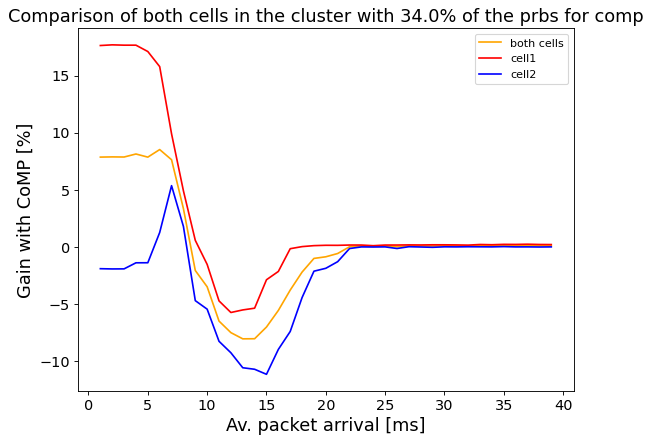

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(mu_range,(l+l2)/2,label='both cells',color='orange')
plt.plot(mu_range,l,label='cell1',color='red')
plt.plot(mu_range,l2,label='cell2',color='blue')
plt.xlabel('Av. packet arrival [ms]')
plt.title('Comparison of both cells in the cluster with '+ str(prb_number_comp*100/max_prb)+'% of the prbs for comp')
plt.ylabel('Gain with CoMP [%]')
plt.legend(loc='upper right')


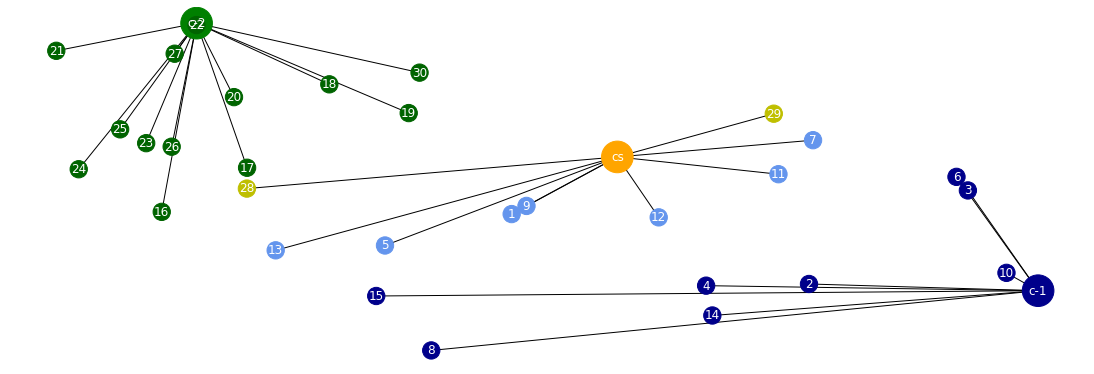

In [60]:
import plotly.graph_objects as go
import networkx as nx

mode='user-assignment'
#mode='comp-gain'

df2 = pd.read_json("Prepro/cell_data.txt")
bs_dict={}
for i in df_cell.index:
    bs_dicht.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lat'],df_cell.loc[i]['lon']]})
    
BS_pos=np.array([])
for i in cluster:
    BS_pos=np.append(BS_pos,bs_dict[i])

G=nx.Graph()

x=np.arange(1,ue_nr*2)
G.add_node('cs')
G.add_node('c-1')
G.add_node('c-2')

loc_dic={}
loc_dic.update({'cs':[(BS_pos[1]+BS_pos[3])/2,(BS_pos[0]+BS_pos[2])/2]})
loc_dic.update({'c-1':[BS_pos[1],BS_pos[0]]}) 
loc_dic.update({'c-2':[BS_pos[3],BS_pos[2]]})     
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    counter+=1

G.add_nodes_from(x)

n_c=np.array(['orange','darkblue','green'])
counter=1
for i in ue_all:
    #loc_dic.update({counter:[i.x,i.y]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
        if(i.cell1==cluster[0]):
            n_c=np.append(n_c,'cornflowerblue')
        elif(i.cell1==cluster[1]):
            n_c=np.append(n_c,'y')
    else:
        if(i.cell1==cluster[0]):
            G.add_edge(counter,'c-1')
            n_c=np.append(n_c,'darkblue')
        elif(i.cell1==cluster[1]):
            G.add_edge(counter,'c-2')
            n_c=np.append(n_c,'darkgreen')
    counter+=1
            
n_s=np.ones(ue_nr*2+3)*300
n_s[0:3]=1000

m=np.array([])
m=np.append(m,[1,1,1])
t=np.array([])
t=np.append(t,[1,1,1])
for i in ue_all:
    m=np.append(m,(i.mR2/i.mR))
    if(i.comp==1):
        t=np.append(t,i.tbs2)
    else:
        t=np.append(t,i.tbs)
vmin = np.min(m)
vmax = np.max(m)
m=10*np.log10(m)

plt.figure(3,figsize=(15,5)) 
#cmap='RdBu'
cmap='RdYlGn'
if(mode=='user-assignment'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=n_c,font_color='white',node_size=n_s)
elif(mode=='comp-gain'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=m,font_color='white',node_size=n_s,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    x=plt.colorbar(sm)
    x.set_label('CoMP gain in [dB]', rotation=270,labelpad=20)
plt.draw()
plt.show()